In [1]:
import os

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

class Reader:

    headers = [
        'INCIDENT_NUMBER',
        'OFFENSE_CODE_GROUP',
        'DISTRICT',
        'SHOOTING',
        'YEAR',
        'MONTH',
        'DAY_OF_WEEK',
        'HOUR',
        'Lat',
        'Long'
    ]

    types = dict(zip(headers, [object, object, object, object, np.int32, np.int32, object, np.int32, np.float64, np.float64]))

    def __init__(self, filename, lat_predicate=lambda entries: entries > 40, lon_predicate=lambda entries: entries < -60):

        if not isinstance(filename, str):
            raise ValueError("'filename' is not an instance of 'str'")

        if not os.path.isdir('out'):
            os.mkdir('out')

        pickled = os.path.splitext(os.path.basename(filename))[0] + '.pkl'

        pickled = os.path.join(os.path.curdir, 'out', pickled)

        if os.path.isfile(pickled):

            print('<LOG>: Loading pickled dataset from', "'" + pickled + "'")

            self.data = pd.read_pickle(pickled)

            print('<LOG>: The dataset consists', len(self.data.index), 'rows and', len(self.data.columns), 'columns')

            return

        print('<LOG>: Processing file', "'" + filename + "'")

        self.data = pd.read_csv(filename, dtype=self.types, skipinitialspace=True, usecols=self.headers)

        print('<LOG>: The dataset consists', len(self.data.index), 'rows and', len(self.data.columns), 'columns')

        self.data['SHOOTING'].fillna('N', inplace=True)

        print('<LOG>: Dropping NaN values')

        self.data.dropna(inplace=True)

        print('<LOG>: Restricting longitude and latitude')

        self.data = self.data[lat_predicate(self.data['Lat']) & (lon_predicate(self.data['Long']))]

        print('<LOG>: Creating column', "'" + 'TIME_PERIOD' + "'")

        self.data['TIME_PERIOD'] = ['Night' if hour <= 6 or hour >= 18 else 'Day' for hour in list(self.data['HOUR'])]

        print('<LOG>: Augmenting the dataset by the factorized equivalent of each column')

        gmin = self.data[['Long', 'Lat']].min().min()
        gmax = self.data[['Long', 'Lat']].max().max()

        for header in self.headers:

            self.data[[header + '_FACTORIZED']] = self.data[[header]].stack().rank(method='dense').unstack()

            self.data[[header + '_FACTORIZED']] = MinMaxScaler((gmin, gmax)).fit_transform(self.data[[header + '_FACTORIZED']])

        print('<LOG>: The dataset consists', len(self.data.index), 'rows and', len(self.data.columns), 'columns')

        print('<LOG>: Saving pickled datafrime to', "'" + pickled + "'")

        self.data.to_pickle(pickled)


    def groupby(self, headers):

        if isinstance(headers, str):
            headers = set([headers])
        elif isinstance(headers, list):
            headers = set(headers)
        else:
            raise ValueError("'headers' must be an instance of 'list'")

        if not headers.issubset(self.headers):
            raise ValueError(headers.difference(self.headers), 'header(s) are not supported')

        return self.data.groupby(list(headers))

In [2]:
from re import sub

from sklearn import cluster

from reader import Reader
from visualizer import Visualizer

class KMeans:

    def __init__(self, reader):

        if not isinstance(reader, Reader):
            raise ValueError("'reader' is not an instance of 'Reader'")

        self.data = reader.data


    def fit(self, n_clusters=None, header=None):

        if header:

            if not isinstance(header, str):
                raise ValueError("'header' is not an instance of 'str'")

            print('<LOG>: Clustering according to geographical location and', "'" + header.replace('_', ' ').title() + "'")

            header = header + '_FACTORIZED'

            data = self.data[['Long', 'Lat', header]]

            n_clusters = len(self.data[header].unique())

        else:

            if not isinstance(n_clusters, int) or n_clusters <= 0:
                raise ValueError("'n_clusters' must have an integer value greater than zero")

            print('<LOG>: Clustering according to geographical location')

            data = self.data[['Long', 'Lat']]

        print('<LOG>: Running kmeans with', '{0:2}'.format(n_clusters), 'clusters')

        return cluster.KMeans(n_clusters=n_clusters).fit(data).labels_.astype(float)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

from reader import Reader

class Visualizer:

    def __init__(self, reader):

        if not isinstance(reader, Reader):
            raise ValueError("'reader' is not an instrance of 'Reader'")

        sns.set(style='whitegrid')

        self.data = reader.data


    def countplot(self, header, title, squeeze=False, predicate=None, figsize=(16, 6), palette='Set3'):

        if not isinstance(header, str):
            raise ValueError("'header' is not an instrance of 'str'")

        if not isinstance(title, str):
            raise ValueError("'title' is not an instrance of 'str'")

        if header == 'DAY_OF_WEEK':
            order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        else:
            order = sorted(self.data[header].unique())

        data = self.data

        if predicate:
            data = data[predicate(data)]

        plt.figure(figsize=figsize)

        axes = sns.countplot(x=header, data=data, order=order, palette=palette)

        if header == 'MONTH':
            axes.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])

        axes.set_title(title)

        axes.set(xlabel='', ylabel='')

        if squeeze:
            axes.set_xticklabels(axes.get_xticklabels(), rotation=90, fontsize=7, ha='left')

            plt.tight_layout()

        plt.show()


    def scatterplot(self, hue, title, figsize=(16, 6), palette='Set2'):

        plt.figure(figsize=figsize)

        axes = sns.scatterplot(x='Long', y='Lat', data=self.data, hue=hue, palette=palette, legend=False)

        axes.set(xlabel='Longitude', ylabel='Latitude')

        if title:
            axes.set_title(title)

        plt.show()

In [34]:
import folium
from folium import IFrame
from folium import Popup
from folium.plugins import MarkerCluster
from IPython.core.display import display

from reader import Reader

table = """
<!DOCTYPE html>
<html>

<head>
    <style>
        #info {{
            font-family: "Trebuchet MS", Arial, Helvetica, sans-serif;
            border-collapse: collapse;
            width: 100%;
        }}

        #info td,
        #info th {{
            border: 1px solid #ddd;
            padding: 8px;
        }}

        #info tr:nth-child(even) {{
            background-color: #f2f2f2;
        }}

        #info tr:hover {{
            background-color: #ddd;
        }}

        #info th {{
            padding-top: 12px;
            padding-bottom: 12px;
            text-align: left;
            background-color: rgb(86, 76, 175);
            color: white;
        }}
    </style>
</head>

<body>

    <table id="info">
        <tr>
            <th>Incident Number</th>
            <th>{}</th>
        </tr>
        <tr>
            <td>{}</td>
            <td>{}</td>
        </tr>
    </table>

</body>

</html>
""".format

class Map:

    def __init__(self, reader, sample_size=500):

        if not isinstance(reader, Reader):
            raise ValueError("'reader' is not an instance of 'Reader'")

        if sample_size:
            if not isinstance(sample_size, int) or sample_size <= 0:
                raise ValueError("'sample_size' must have an integer value greater than zero")

            self.sample_size = sample_size

            self.data = reader.data.sample(n=sample_size)

        else:
            self.data = reader.data

        self.center_x, self.center_y = self.data['Lat'].mean(), self.data['Long'].mean()


    def display(self, header, predicate=None, zoom_start=11, popup_width=400, popup_height=100):

        if not isinstance(header, str):
            raise ValueError("'header' is not an instance of 'str'")

        data = self.data[['INCIDENT_NUMBER', 'Lat', 'Long', header]]

        if predicate:
            data = data[predicate(self.data)]

        locations, popups = {}, {}

        formatted_header = header.replace('_', ' ').title()

        for _, row in data.iterrows():

            if not row[header] in locations:
                locations[row[header]] = []
                popups[row[header]] = []

            locations[row[header]].append([row['Lat'], row['Long']])

            html = table(formatted_header, row['INCIDENT_NUMBER'], str(row[header]).title())

            ifrm = IFrame(html=html, width=popup_width, height=popup_height)

            popups[row[header]].append(Popup(ifrm))

        underlying = folium.Map(location=[self.center_x, self.center_y], zoom_start=zoom_start)

        for key in locations.keys():

            group = folium.FeatureGroup(str(key).title())

            group.add_child(MarkerCluster(locations[key], popups[key]))

            underlying.add_child(group)

        underlying.add_child(folium.LayerControl())

        display(underlying)

In [5]:
reader = Reader('../data/crime.csv')

<LOG>: Loading pickled dataset from '.\out\crime.pkl'
<LOG>: The dataset consists 305542 rows and 21 columns


In [6]:
visualizer = Visualizer(reader)

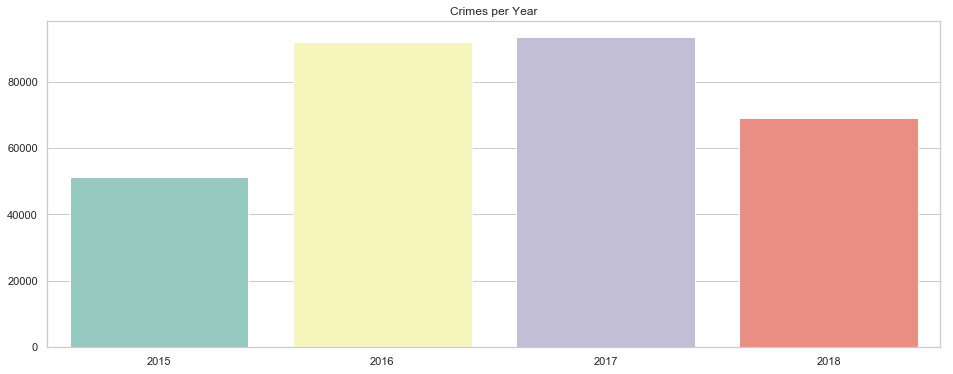

In [7]:
visualizer.countplot('YEAR', 'Crimes per Year')

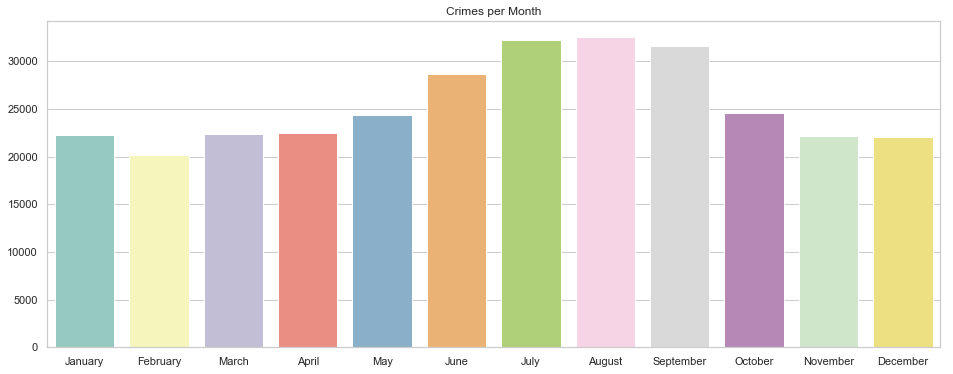

In [8]:
visualizer.countplot('MONTH', 'Crimes per Month')

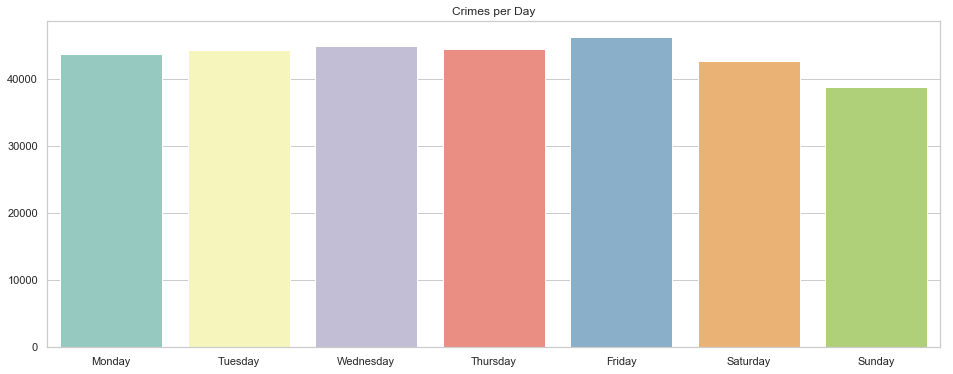

In [9]:
visualizer.countplot('DAY_OF_WEEK', 'Crimes per Day')

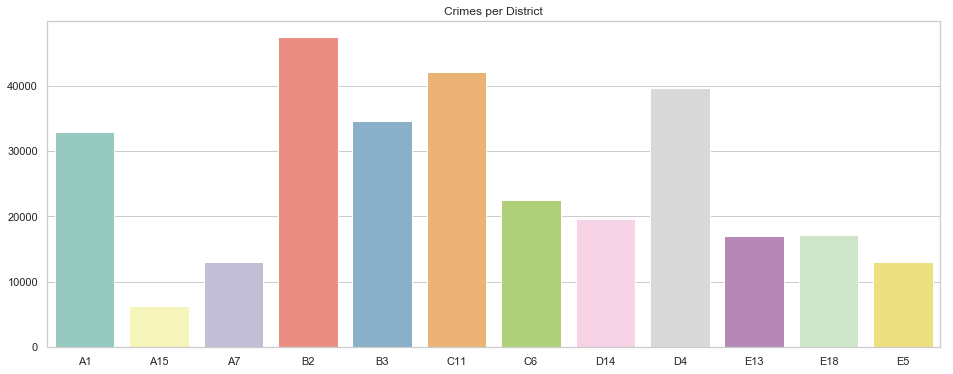

In [10]:
visualizer.countplot('DISTRICT', 'Crimes per District')

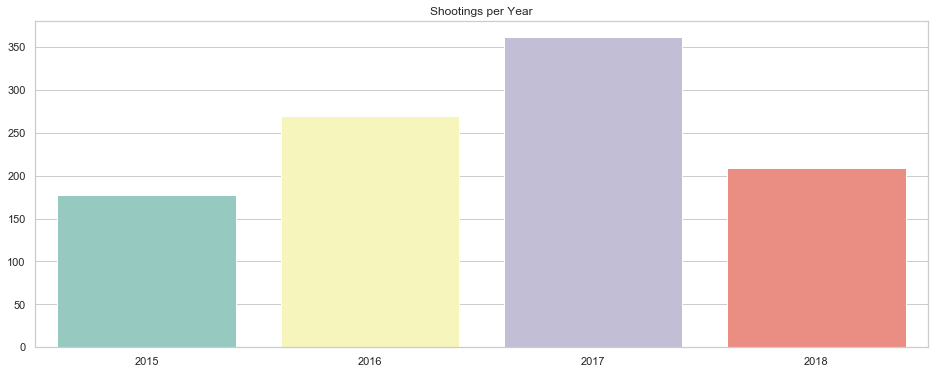

In [11]:
visualizer.countplot('YEAR', 'Shootings per Year', predicate=lambda data: data['SHOOTING'] == 'Y')

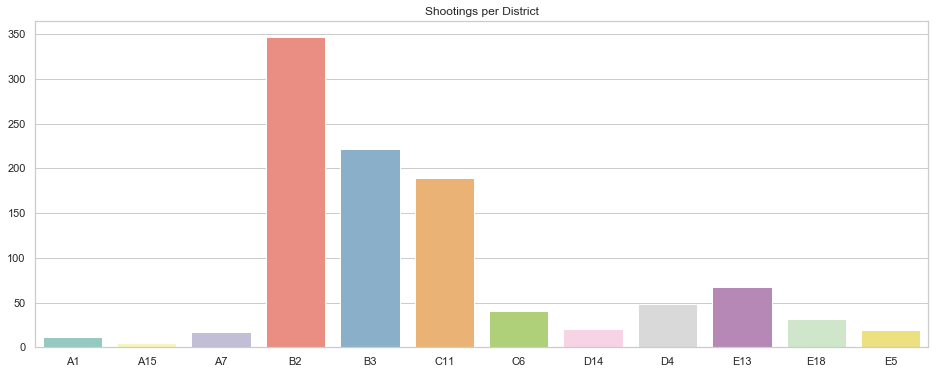

In [12]:
visualizer.countplot('DISTRICT', 'Shootings per District', predicate=lambda data: data['SHOOTING'] == 'Y')

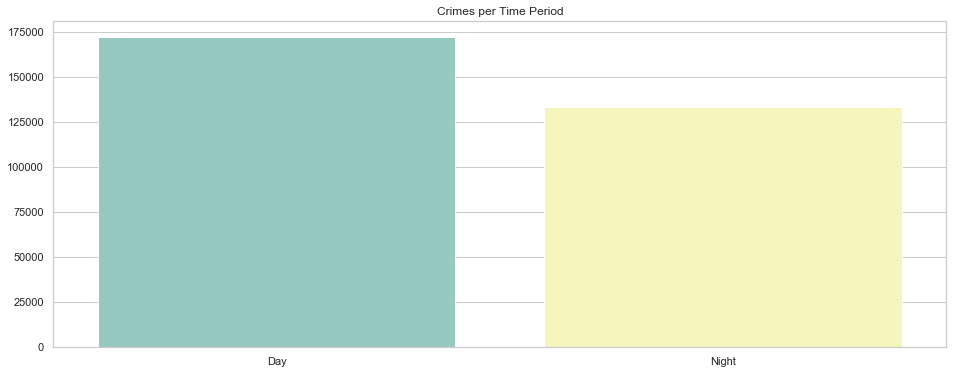

In [13]:
visualizer.countplot('TIME_PERIOD', 'Crimes per Time Period')

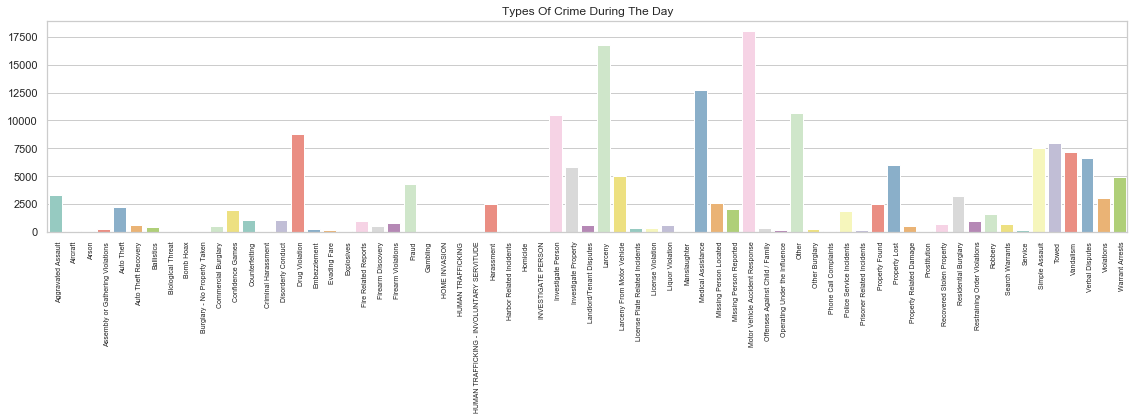

In [14]:
visualizer.countplot('OFFENSE_CODE_GROUP', 'Types Of Crime During The Day', predicate=lambda data: data['TIME_PERIOD'] == 'Day', squeeze=True)

In [15]:
title = 'Geospatial Clustering [{} clusters]'

<LOG>: Clustering according to geographical location
<LOG>: Running kmeans with  2 clusters


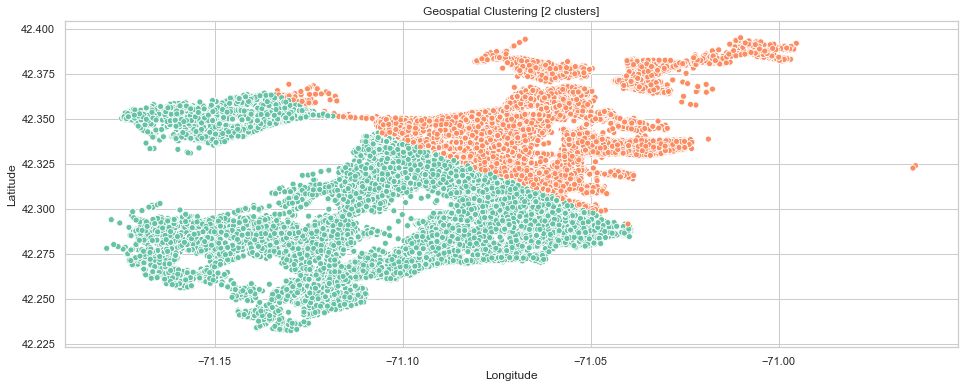

In [16]:
visualizer.scatterplot(KMeans(reader).fit(2), title.format(2))

<LOG>: Clustering according to geographical location
<LOG>: Running kmeans with  3 clusters


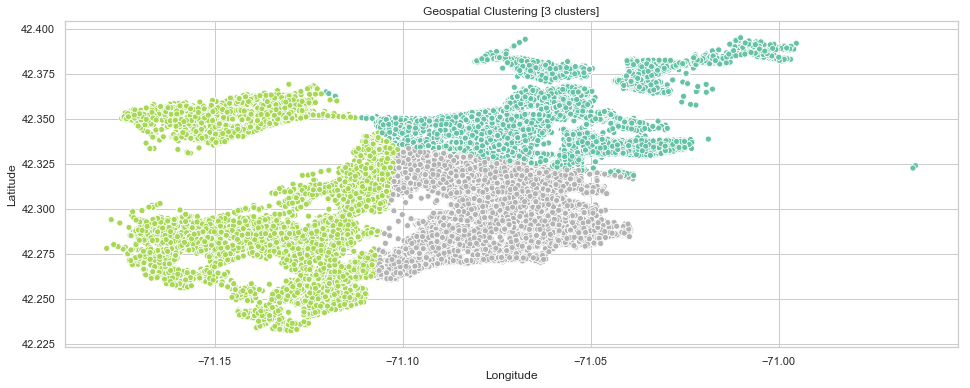

In [17]:
visualizer.scatterplot(KMeans(reader).fit(3), title.format(3))

<LOG>: Clustering according to geographical location
<LOG>: Running kmeans with  5 clusters


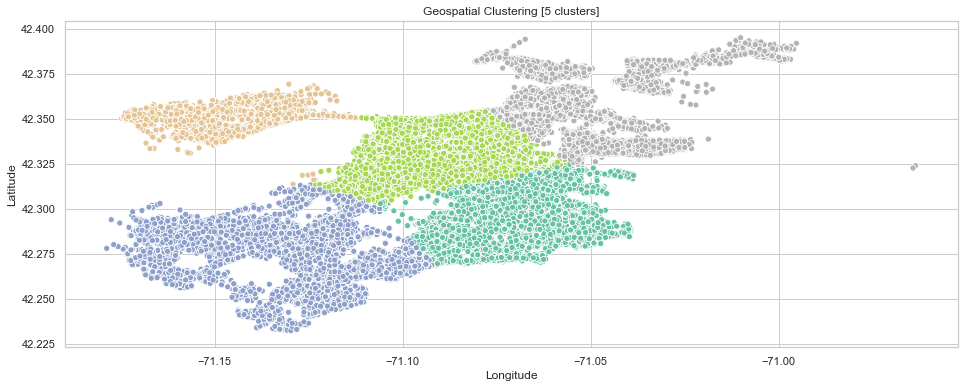

In [18]:
visualizer.scatterplot(KMeans(reader).fit(5), title.format(5))

<LOG>: Clustering according to geographical location
<LOG>: Running kmeans with 10 clusters


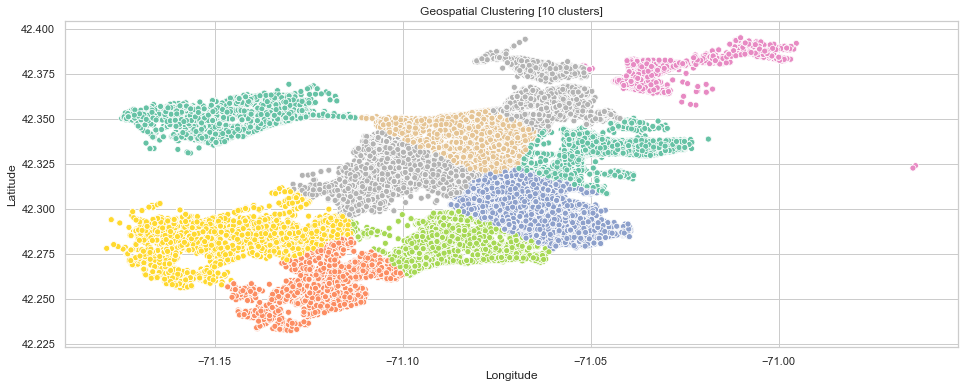

In [19]:
visualizer.scatterplot(KMeans(reader).fit(10), title.format(10))

<LOG>: Clustering according to geographical location and 'Month'
<LOG>: Running kmeans with 12 clusters


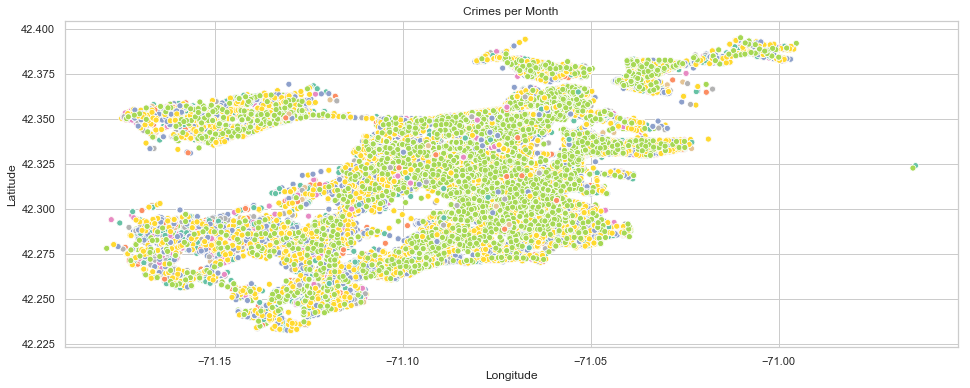

In [20]:
visualizer.scatterplot(KMeans(reader).fit(header='MONTH'), 'Crimes per Month')

<LOG>: Clustering according to geographical location and 'Offense Code Group'
<LOG>: Running kmeans with 67 clusters


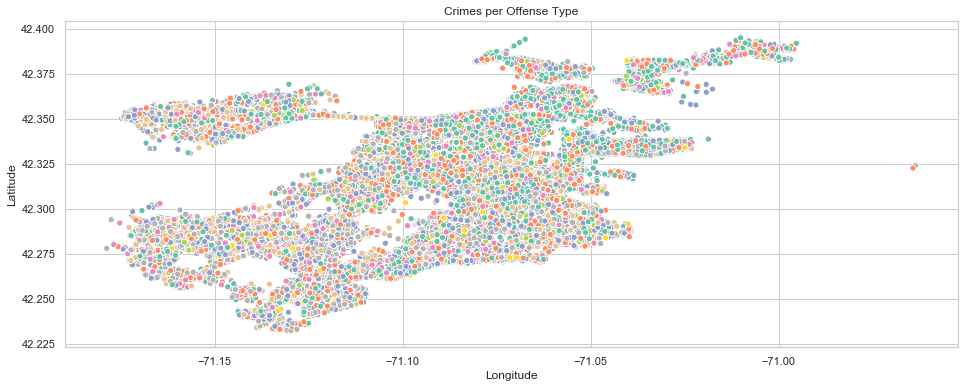

In [21]:
visualizer.scatterplot(KMeans(reader).fit(header='OFFENSE_CODE_GROUP'), 'Crimes per Offense Type')

In [35]:
Map(reader).display('OFFENSE_CODE_GROUP')